In [1]:
import numpy as np
import gym
from successor_representation.environments import GridWorld
from successor_representation.agents import SRRandomAgent, SRQLearningAgent
from successor_representation.utils import run_episodic, run_non_episodic, compute_sr_vec, render_sr
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib import colors
from copy import deepcopy
from IPython.display import clear_output
%matplotlib inline

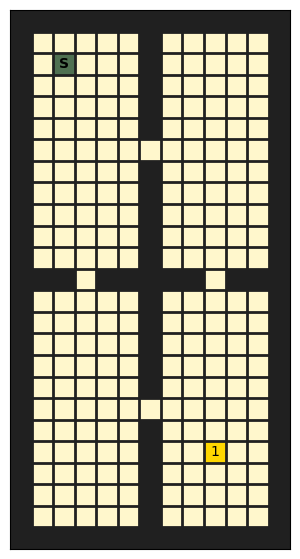

In [2]:
layout = np.loadtxt("../environments/gridworld_layouts/four_rooms.txt", comments="//", dtype=str)
env = GridWorld(layout, init_coords=[(2, 2)], terminal_coords=[(20, 9)], reward_coords={(20, 9): 1}, stochasticity=0., default_reward=-0.01)
env.name = "four_rooms"
env.reset()
env.render()

Learning the SR with TD learning:

$$\mathbf{\Psi}_\pi $$


von-Neumann series computation of SR:
$$\mathbf{\Psi}_\pi = \sum^\infty_{t=0}\left(\gamma \mathbf{P}_\pi\right)^t = \left(\mathbf{I}-\gamma \mathbf{P}_\pi\right)^{-1}$$

In [3]:
env.coord_to_valid_state[(20, 9)]

191

In [4]:
agent = SRRandomAgent(env.num_valid_states)
buffer, _, epi_steps = run_non_episodic(agent, env=env, num_interactions=120000, terminating=False, save=False)

In [6]:
agent.sr[191]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype

In [ ]:
for transition in buffer:
    if env._obs_to_state(transition["obs"]) == (20, 9):
        print("hi")

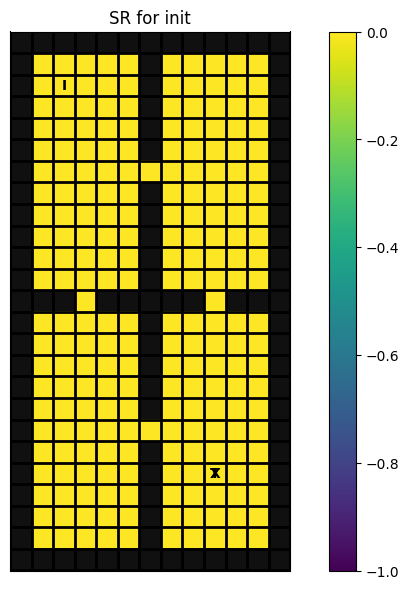

In [5]:
render_sr(env, deepcopy(agent.sr), (20, 9), "SR for init")

In [ ]:
agent.sr[]

## Successor Features